In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [4]:
def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [5]:
''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

(8, 8) (1, 8)
(8, 8) (1, 8)
Alphas for hard margins:  [[1.93859701e-11]
 [1.81090229e-11]
 [8.68832926e-12]
 [1.89237318e-11]
 [2.04487893e-11]
 [1.39686355e-11]
 [1.00776400e-09]
 [1.66960974e-11]
 [1.55569513e-11]
 [1.77458045e-09]
 [1.85988525e-11]
 [1.17780335e-10]
 [9.89329395e-12]
 [1.10221906e-11]
 [1.98651732e-11]
 [9.27538693e-12]
 [1.52136709e-11]
 [1.58018968e-11]
 [1.03976731e-11]
 [2.43569883e-11]
 [1.92747355e-11]
 [9.50576918e+00]
 [8.00068922e-12]
 [2.03679177e-11]
 [8.41795615e-12]
 [1.37053103e-11]
 [5.94927310e+01]
 [3.86754011e-11]
 [1.15582459e-10]
 [1.89050235e-11]
 [7.17666889e-12]
 [3.67127205e-11]
 [7.45053059e-11]
 [1.49653704e+01]
 [5.49694265e-11]
 [4.70520825e-11]
 [3.98346587e+01]
 [3.77124652e-11]
 [1.73991872e-11]
 [1.23688219e-11]
 [3.47691539e-11]
 [1.95593123e-11]
 [2.96708090e-11]
 [8.15384114e+00]
 [1.30444303e-11]
 [4.17153730e-01]
 [9.42160563e-12]
 [1.57644177e-11]
 [1.78818872e-11]
 [2.12544232e-11]
 [7.04420940e-12]
 [1.33216300e-11]
 [9.636981

In [6]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)

Alphas for soft margins:  [[3.39007786e-12]
 [1.30651441e-12]
 [1.30383508e-12]
 [3.29432696e-12]
 [3.77705861e-12]
 [2.03246410e-12]
 [2.53342837e-10]
 [2.88880634e-12]
 [3.17264074e-12]
 [2.11748011e-10]
 [2.55211643e-12]
 [3.36025887e-11]
 [1.43246906e-12]
 [1.54090392e-12]
 [4.31010014e-12]
 [1.55567628e-12]
 [2.90767575e-12]
 [2.73817776e-12]
 [1.69962793e-12]
 [4.43409768e-12]
 [3.69958251e-12]
 [9.50576900e+00]
 [1.09950700e-12]
 [1.68459776e-12]
 [1.36067440e-12]
 [1.02390007e-12]
 [5.94927311e+01]
 [7.91760029e-12]
 [6.09332042e-11]
 [2.97207841e-12]
 [8.30338033e-13]
 [7.62022701e-12]
 [1.70005686e-11]
 [1.49653706e+01]
 [1.13628897e-11]
 [1.33251405e-11]
 [3.98346587e+01]
 [7.26644260e-12]
 [2.63625736e-12]
 [1.03752018e-12]
 [6.48118654e-12]
 [4.30889912e-12]
 [6.04541472e-12]
 [8.15384112e+00]
 [1.54119698e-12]
 [4.17153612e-01]
 [7.56818227e-13]
 [2.65552438e-12]
 [3.43812544e-12]
 [3.45555792e-12]
 [1.01269950e-12]
 [2.52463815e-12]
 [1.53756650e-12]
 [2.14325188e-12]
 [

<a list of 4 text.Text objects>

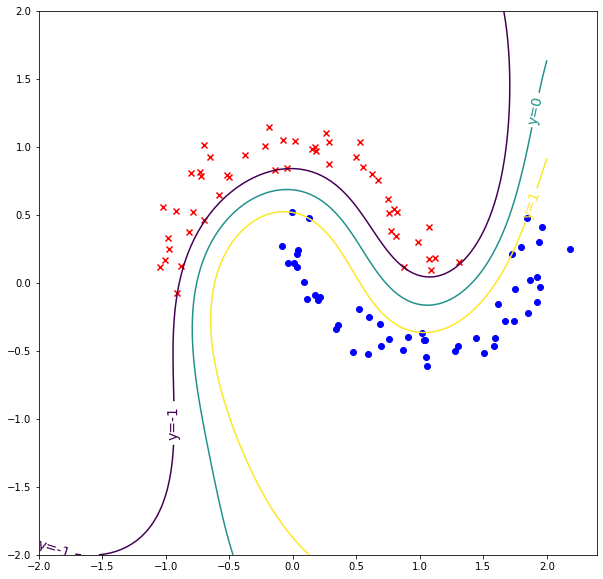

In [7]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=14)

<a list of 3 text.Text objects>

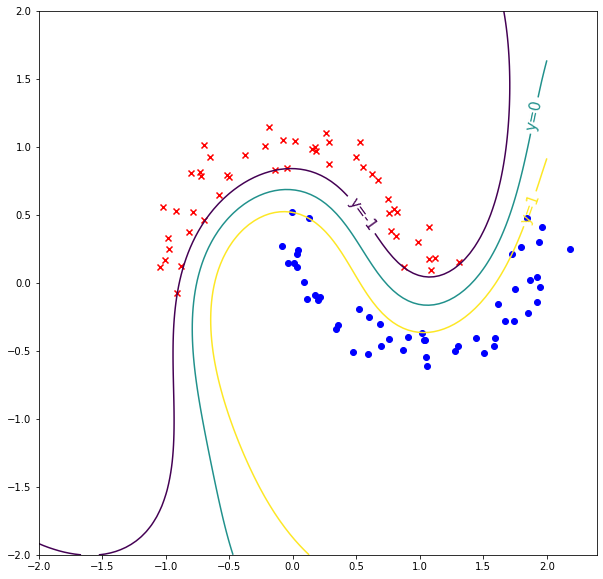

In [8]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)